In [ ]:
!pip install nltk

In [ ]:
!pip install yake

In [ ]:
!pip install pyLDAvis

In [ ]:
import nltk
import os
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import numpy as np
from gensim.models import Nmf
from gensim.models.ldamodel import LdaModel
from gensim.models import LsiModel
from gensim.models import HdpModel
from gensim.models import LdaMulticore
from gensim.models import EnsembleLda
from gensim.models.ldamulticore import LdaMulticore
from gensim.models.coherencemodel import CoherenceModel
import gensim
import gensim.corpora as corpora
from gensim.models import Phrases
from gensim.utils import simple_preprocess
from gensim.corpora.dictionary import Dictionary
from gensim.utils import tokenize
from nltk.corpus import stopwords
from collections import Counter
nltk.download('stopwords')
nltk.download('wordnet')
import re
import json
import string
from bs4 import BeautifulSoup
from gensim.parsing.preprocessing import (
    strip_non_alphanum,
    split_alphanum,
    strip_short,
    strip_numeric
)
import yake
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models
import pyLDAvis.gensim

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
datafile = 'latest_ticket_data.csv'
data = pd.read_csv(datafile)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data['Description'] = data['Description'].str.lower()
data['Description'] = data['Description'].astype(str)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
stop_words = stopwords.words('english')
custom_stop_words = ['hi', 'since', 'please', 'best', 'regards', 'thank', 'thanks', 'hello', 'sent', 'great', 'dear', 'help', 'kind']
time_words = ['january', 'february', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 'october', 'november', 'december', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'today' , 'yesterday', 'tomorrow', 'hour', 'hours', 'time', 'times', 'timelines', 'date', 'day', 'days', 'am', 'pm', 'morning', 'noon', 'afternoon', 'evening', 'night', 'winter', 'summer', 'rain', 'cold']

def remove_stop_words(text):
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
    text = pattern.sub('', text)
    return text

def remove_custom_words(text):
    pattern = re.compile(r'\b(' + r'|'.join(custom_stop_words) + r')\b\s*')
    text = pattern.sub('', text)
    return text

def remove_time_words(text):
    pattern = re.compile(r'\b(' + r'|'.join(time_words) + r')\b\s*')
    text = pattern.sub('', text)
    return text

data['Description'] = data["Description"].map(lambda x: remove_stop_words(x))
data['Description'] = data["Description"].map(lambda x: remove_custom_words(x))
data['Description'] = data["Description"].map(lambda x: remove_time_words(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def parse_html(text, parser="html.parser"):
    soup = BeautifulSoup(text, parser)
    soup = remove_html_tags(soup)
    text = remove_multiple_space(soup.get_text()).strip()
    return text


def parse_html_v2(text, loop=2, parser="html.parser"):
    if not text:
        text = ""
    # some contents still have html code after first parse
    # loop solved problem
    for _ in range(loop):
        soup = BeautifulSoup(text, parser)
        text = soup.get_text()
    text = remove_multiple_space(text)
    return text


def remove_links_content(text):
    text = re.sub(r"http\S+", "", text)
    return text


def remove_emails(text):
    return re.sub('\S*@\S*\s?', '', text)  # noqa


def remove_punctuation(text):
    """https://stackoverflow.com/a/37221663"""
    table = str.maketrans({key: None for key in string.punctuation})
    return text.translate(table)


def remove_special_tags(text):
    """Remove html tags from a string"""
    clean = re.compile('{.*?}')
    return re.sub(clean, '', text)


def preprocess_text(text):
    text = parse_html_v2(text)
    text = text.lower()
    text = remove_links_content(text)
    text = remove_emails(text)
    text = remove_special_tags(text)  # remove content between {}
    text = remove_punctuation(text)  # remove all puntuations
    text = split_alphanum(text)  # add space between word and numeric
    text = strip_numeric(text)  # remove digits
    text = strip_non_alphanum(text)  # remove non-alphabetic characters
    text = strip_short(text, minsize=2)  # remove word with length  <  minsize
    text = remove_multiple_space(text).strip()  # remove space and strip
    #text = tokenize(text)
    return text


def remove_multiple_space(text):
    return re.sub("\s\s+", " ", text)  # noqa


def remove_html_tags(soup,
                     tags=["script", "style"],
                     get_text=False):
    for tag in tags:
        for sample in soup.find_all(tag):
            sample.replaceWith('')

    if get_text:
        return soup.get_text()
    return soup

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:26: DeprecationWarning: invalid escape sequence '\S'
<>:58: DeprecationWarning: invalid escape sequence '\s'
<>:26: DeprecationWarning: invalid escape sequence '\S'
<>:58: DeprecationWarning: invalid escape sequence '\s'
<ipython-input-8-9c3902e42405>:26: DeprecationWarning: invalid escape sequence '\S'
  return re.sub('\S*@\S*\s?', '', text)  # noqa
<ipython-input-8-9c3902e42405>:58: DeprecationWarning: invalid escape sequence '\s'
  return re.sub("\s\s+", " ", text)  # noqa


In [ ]:
# Convert body column to string for performing text operations
data['Description'] = data['Description'].astype(str)
data['Description'] =data["Description"].map(lambda x: preprocess_text(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lemmatizer = WordNetLemmatizer()
data['Lemma_Description'] = data["Description"].map(lambda x: lemmatizer.lemmatize(x))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))


x = data['Lemma_Description'].values.tolist()
docs = list(sent_to_words(x))
bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Remove rare & common tokens
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)
#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 1365
Number of documents: 3000
[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1)]]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Set parameters.
num_topics = 5
chunksize = 500
passes = 20
iterations = 400
eval_every = 1
id2word = dictionary

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
LE = LabelEncoder()
data['Label'] = LE.fit_transform(data['Category'])
print(data)

                                            Description     Category  \
0     recruiter lead permission approve requisitions...  Application   
1     expire ask update passwords colleagues expire ...  Application   
2     verification warning got attached addresses mo...  Application   
3     looks blacklisted receiving mails anymore samp...  Application   
4                       modules report report cost much  Application   
...                                                 ...          ...   
2995  feedback follow conf call setup meeting one co...     Database   
2996  issues keep getting errors errors preventing s...     Database   
2997  en working properly guys issue number en locat...     Database   
2998  log incident laptop engineer managed got feedb...     Database   
2999  connection issues connection issues working cl...     Database   

                                      Lemma_Description  Label  
0     recruiter lead permission approve requisitions...      0  
1    

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:605: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:614: DeprecationWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):


In [ ]:
from sklearn.metrics import accuracy_score
def getLDAModelAccuracy(model, corpus, dataset, Label):
  get_document_topics = [model.get_document_topics(item) for item in corpus]
  np_array_of_objects = np.asarray(get_document_topics, dtype="object")
  pred_df = pd.DataFrame(columns=['pred_label'])
  length = len(pd.DataFrame(np_array_of_objects)[0])
  dict_list = []
  for i in range(0,length):
    count=len(pd.DataFrame(np_array_of_objects)[0][i])
    max=0
    for j in range(0,count):
      if(max < (pd.DataFrame(np_array_of_objects)[0][i])[j][1]):
        max=(pd.DataFrame(np_array_of_objects)[0][i])[j][1]
        label=(pd.DataFrame(np_array_of_objects)[0][i])[j][0]
    row_dict = {'pred_label': label}
    dict_list.append(row_dict)
  pred_df = pd.DataFrame.from_dict(dict_list)
  y_pred = pred_df['pred_label'].values
  y_true = dataset['Label'].values
  return(accuracy_score(y_true, y_pred))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#lda model
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, '0.050*"visitor" + 0.034*"visitor_cards" + 0.028*"card" + 0.020*"cards" + 0.019*"visitor_visitor" + 0.018*"name" + 0.015*"consider_environment" + 0.015*"information" + 0.014*"printer" + 0.013*"activate_card"'), (1, '0.034*"details" + 0.027*"event" + 0.025*"details_details" + 0.021*"form" + 0.018*"find_attached" + 0.017*"secure_area" + 0.016*"meeting_room" + 0.016*"data_event" + 0.016*"event_notification" + 0.016*"attached"'), (2, '0.020*"floor" + 0.012*"analyst_ext" + 0.010*"area" + 0.010*"cards" + 0.009*"senior_engineer" + 0.009*"badge" + 0.009*"leaver" + 0.008*"update" + 0.008*"engineer" + 0.008*"door"'), (3, '0.058*"la" + 0.053*"si" + 0.038*"va" + 0.038*"card" + 0.031*"ca" + 0.026*"care" + 0.023*"se" + 0.023*"engineer_ext" + 0.023*"purchase_po" + 0.022*"sa"'), (4, '0.030*"access" + 0.024*"importance_high" + 0.022*"card" + 0.018*"access_card" + 0.018*"lost" + 0.016*"could" + 0.016*"th_floor" + 0.016*"lost_access" + 0.015*"en" + 0.014*"let_know"')]


In [ ]:
getLDAModelAccuracy(lda_model,corpus,data,"Label")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.136

In [ ]:
c_v_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_lda = c_v_coherence_model_lda.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



C_V Coherence Score:  0.35141063336895284


In [ ]:
u_mass_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence_model_lda.get_coherence()
print('\nU_Mass Coherence Score: ', u_mass_coherence_lda)


U_Mass Coherence Score:  -7.810291809832217


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
c_uci_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda = c_uci_coherence_model_lda.get_coherence()
print('\nc_uciCoherence Score: ', c_uci_coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



c_uciCoherence Score:  -6.1913673243819005


In [ ]:
c_npmi_coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda = c_npmi_coherence_model_lda.get_coherence()
print('\c_npmi_Coherence Score: ', c_npmi_coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence '\c'
<>:3: DeprecationWarning: invalid escape sequence '\c'
<ipython-input-22-fa0b98051792>:3: DeprecationWarning: invalid escape sequence '\c'
  print('\c_npmi_Coherence Score: ', c_npmi_coherence_lda)


\c_npmi_Coherence Score:  -0.17032319238826224


In [ ]:
#lda multicore model
lda_multicore_model = LdaMulticore(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       eta='auto', \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every)
# Print the Keyword in the 5 topics
print(lda_multicore_model.print_topics())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0, '0.036*"name" + 0.032*"leaver" + 0.024*"form" + 0.021*"disk" + 0.020*"find_attached" + 0.017*"details" + 0.015*"starter_form" + 0.014*"leaver_form" + 0.014*"warning" + 0.014*"assigned"'), (1, '0.064*"card" + 0.044*"la" + 0.043*"si" + 0.030*"va" + 0.024*"purchase_po" + 0.024*"ca" + 0.022*"item" + 0.022*"visitor" + 0.022*"receive_item" + 0.020*"care"'), (2, '0.022*"cards" + 0.014*"visitor_cards" + 0.013*"officer" + 0.013*"information" + 0.011*"meeting_room" + 0.011*"floor" + 0.010*"area" + 0.009*"also" + 0.009*"annual_leave" + 0.008*"leave"'), (3, '0.032*"senior_engineer" + 0.030*"engineer" + 0.026*"th_floor" + 0.021*"log" + 0.020*"access_card" + 0.020*"floor" + 0.015*"engineer_ext" + 0.013*"th" + 0.013*"details" + 0.011*"senior"'), (4, '0.022*"importance_high" + 0.018*"access" + 0.015*"event" + 0.013*"could" + 0.012*"issue" + 0.011*"let_know" + 0.011*"problem" + 0.010*"laptop" + 0.010*"en" + 0.009*"lost"')]


In [ ]:
getLDAModelAccuracy(lda_multicore_model,corpus,data,"Label")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.16666666666666666

In [ ]:
c_v_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_lda_multicore = c_v_coherence_model_lda_multicore.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_lda_multicore)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



C_V Coherence Score:  0.33307470338508


In [ ]:
u_mass_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda_multicore = u_mass_coherence_model_lda_multicore.get_coherence()
print('\nu_mass Coherence Score: ', u_mass_coherence_lda_multicore)


u_mass Coherence Score:  -7.184066268427546


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
c_uci_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda_multicore = c_uci_coherence_model_lda_multicore.get_coherence()
print('\nc_uci Coherence Score: ', c_uci_coherence_lda_multicore)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



c_uci Coherence Score:  -5.8686749016444235


In [ ]:
c_npmi_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda_multicore = c_npmi_coherence_model_lda_multicore.get_coherence()
print('\nc_npmi Coherence Score: ', c_npmi_coherence_lda_multicore)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



c_npmi Coherence Score:  -0.15961908661182134


In [ ]:
df_0 = data.loc[(data['Label'] == 0)]
df_1 = data.loc[(data['Label'] == 1)]
df_2 = data.loc[(data['Label'] == 2)]
df_3 = data.loc[(data['Label'] == 3)]
df_4 = data.loc[(data['Label'] == 4)]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Instantiate (set n-word groupings hyperparameters to 2)
kw_extractor = yake.KeywordExtractor(n=1)
keywords = df_0['Description'].apply(kw_extractor.extract_keywords)
# Extract scores from the YAKE output
text = []
for list in keywords:
    for component in list:
        text.append(str(component[0]))

# Bar plot - Create a dataframe of the most common 20 words
common_words = pd.DataFrame(Counter(text).most_common(20))
common_words.columns = ('Word', 'Count')
label_0 = [common_words['Word'][0],common_words['Word'][1], common_words['Word'][2],common_words['Word'][3],common_words['Word'][4]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Instantiate (set n-word groupings hyperparameters to 2)
kw_extractor = yake.KeywordExtractor(n=1)
keywords = df_1['Description'].apply(kw_extractor.extract_keywords)
# Extract scores from the YAKE output
text = []
for list in keywords:
    for component in list:
        text.append(str(component[0]))

# Bar plot - Create a dataframe of the most common 20 words
common_words = pd.DataFrame(Counter(text).most_common(20))
common_words.columns = ('Word', 'Count')
label_1 = [common_words['Word'][0],common_words['Word'][1], common_words['Word'][2],common_words['Word'][3],common_words['Word'][4]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Instantiate (set n-word groupings hyperparameters to 2)
kw_extractor = yake.KeywordExtractor(n=1)
keywords = df_2['Description'].apply(kw_extractor.extract_keywords)
# Extract scores from the YAKE output
text = []
for list in keywords:
    for component in list:
        text.append(str(component[0]))

# Bar plot - Create a dataframe of the most common 20 words
common_words = pd.DataFrame(Counter(text).most_common(20))
common_words.columns = ('Word', 'Count')
label_2 = [common_words['Word'][0],common_words['Word'][1], common_words['Word'][2],common_words['Word'][3],common_words['Word'][4]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Instantiate (set n-word groupings hyperparameters to 2)
kw_extractor = yake.KeywordExtractor(n=1)
keywords = df_3['Description'].apply(kw_extractor.extract_keywords)
# Extract scores from the YAKE output
text = []
for list in keywords:
    for component in list:
        text.append(str(component[0]))

# Bar plot - Create a dataframe of the most common 20 words
common_words = pd.DataFrame(Counter(text).most_common(20))
common_words.columns = ('Word', 'Count')
label_3 = [common_words['Word'][0],common_words['Word'][1], common_words['Word'][2],common_words['Word'][3],common_words['Word'][4]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Instantiate (set n-word groupings hyperparameters to 2)
kw_extractor = yake.KeywordExtractor(n=1)
keywords = df_4['Description'].apply(kw_extractor.extract_keywords)
# Extract scores from the YAKE output
text = []
for list in keywords:
    for component in list:
        text.append(str(component[0]))

# Bar plot - Create a dataframe of the most common 20 words
common_words = pd.DataFrame(Counter(text).most_common(20))
common_words.columns = ('Word', 'Count')
label_4 = [common_words['Word'][0],common_words['Word'][1], common_words['Word'][2],common_words['Word'][3],common_words['Word'][4]]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
ps = PorterStemmer()

label_0 = [ps.stem(word) for word in label_0]
label_1 = [ps.stem(word) for word in label_1]
label_2 = [ps.stem(word) for word in label_2]
label_3 = [ps.stem(word) for word in label_3]
label_4 = [ps.stem(word) for word in label_4]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
label_topics = {}
for word in label_0:
    label_topics[word] = 0
for word in label_1:
    label_topics[word] = 1
for word in label_2:
    label_topics[word] = 2
for word in label_3:
    label_topics[word] = 3
for word in label_4:
    label_topics[word] = 4

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def create_eta(priors, etadict, ntopics):
    eta = np.full(shape=(ntopics, len(etadict)), fill_value=1) # create a (ntopics, nterms) matrix and fill with 1
    for word, topic in priors.items(): # for each word in the list of priors
        keyindex = [index for index,term in etadict.items() if term==word] # look up the word in the dictionary
        if (len(keyindex)>0): # if it's in the dictionary
            eta[topic,keyindex[0]] = 1e7  # put a large number in there
    eta = np.divide(eta, eta.sum(axis=0)) # normalize so that the probabilities sum to 1 over all topics
    return eta

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
eta_label = create_eta(label_topics, dictionary, 5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#lda model
label_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, chunksize=chunksize, \
                       alpha='auto', eta=eta_label, \
                       iterations=iterations, num_topics=num_topics, \
                       passes=passes, eval_every=eval_every, per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
getLDAModelAccuracy(label_lda_model,corpus,data,"Label")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.24066666666666667

In [ ]:
for num, params in label_lda_model.print_topics():
    print(f'{num}: {params}\n')

0: 0.019*"importance_high" + 0.014*"th_floor" + 0.013*"issue" + 0.010*"en" + 0.010*"could" + 0.009*"engineer" + 0.009*"let_know" + 0.009*"working" + 0.008*"laptop" + 0.008*"also"

1: 0.042*"leaver" + 0.040*"area" + 0.035*"form" + 0.025*"find_attached" + 0.024*"secure_area" + 0.024*"officer" + 0.022*"tower" + 0.021*"floor" + 0.020*"secure" + 0.019*"starter_form"

2: 0.029*"event" + 0.023*"details" + 0.017*"server" + 0.017*"name" + 0.015*"details_details" + 0.013*"original_message" + 0.012*"engineer_ext" + 0.012*"information" + 0.011*"senior_developer" + 0.010*"floor"

3: 0.086*"card" + 0.055*"access" + 0.033*"la" + 0.032*"access_card" + 0.032*"lost" + 0.030*"si" + 0.029*"cards" + 0.028*"visitor" + 0.028*"lost_access" + 0.025*"analyst_ext"

4: 0.034*"senior_engineer" + 0.025*"log" + 0.022*"purchase_po" + 0.021*"item" + 0.020*"receive_item" + 0.015*"engineer" + 0.015*"status" + 0.015*"assigned" + 0.014*"annual_leave" + 0.013*"receive"



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
for i in range(0, label_lda_model.num_topics-1):
  print(label_lda_model.print_topic(i))

0.019*"importance_high" + 0.014*"th_floor" + 0.013*"issue" + 0.010*"en" + 0.010*"could" + 0.009*"engineer" + 0.009*"let_know" + 0.009*"working" + 0.008*"laptop" + 0.008*"also"
0.042*"leaver" + 0.040*"area" + 0.035*"form" + 0.025*"find_attached" + 0.024*"secure_area" + 0.024*"officer" + 0.022*"tower" + 0.021*"floor" + 0.020*"secure" + 0.019*"starter_form"
0.029*"event" + 0.023*"details" + 0.017*"server" + 0.017*"name" + 0.015*"details_details" + 0.013*"original_message" + 0.012*"engineer_ext" + 0.012*"information" + 0.011*"senior_developer" + 0.010*"floor"
0.086*"card" + 0.055*"access" + 0.033*"la" + 0.032*"access_card" + 0.032*"lost" + 0.030*"si" + 0.029*"cards" + 0.028*"visitor" + 0.028*"lost_access" + 0.025*"analyst_ext"


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
c_v_coherence_model_labellda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_labellda = c_v_coherence_model_labellda.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_labellda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



C_V Coherence Score:  0.3927346452311236


In [ ]:
u_mass_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda = u_mass_coherence_model_lda.get_coherence()
print('\nU_Mass Coherence Score: ', u_mass_coherence_lda)


U_Mass Coherence Score:  -6.785699939044838


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
c_uci_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda = c_uci_coherence_model_lda.get_coherence()
print('\nc_uciCoherence Score: ', c_uci_coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



c_uciCoherence Score:  -5.081238804049777


In [ ]:
c_npmi_coherence_model_lda = CoherenceModel(model=label_lda_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda = c_npmi_coherence_model_lda.get_coherence()
print('\c_npmi_Coherence Score: ', c_npmi_coherence_lda)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<>:3: DeprecationWarning: invalid escape sequence '\c'
<>:3: DeprecationWarning: invalid escape sequence '\c'
<ipython-input-46-8178b71267e8>:3: DeprecationWarning: invalid escape sequence '\c'
  print('\c_npmi_Coherence Score: ', c_npmi_coherence_lda)


\c_npmi_Coherence Score:  -0.11808084530726279


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


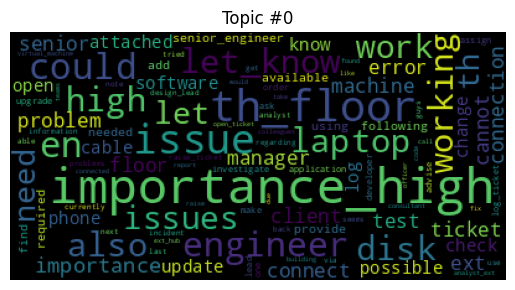

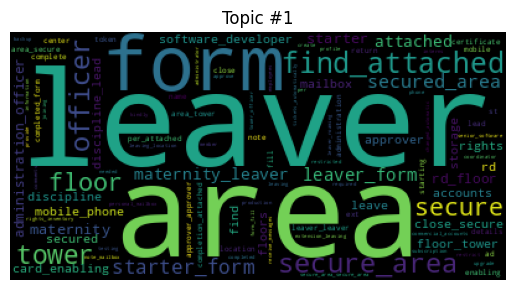

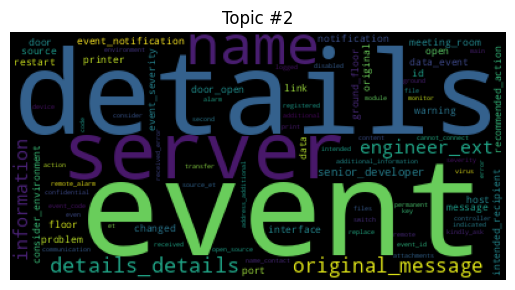

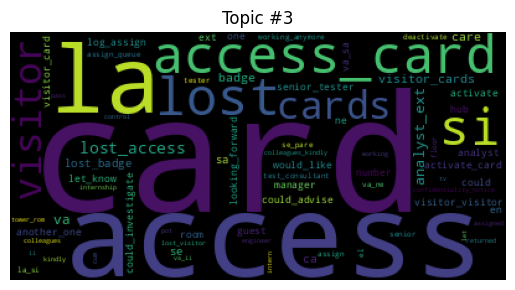

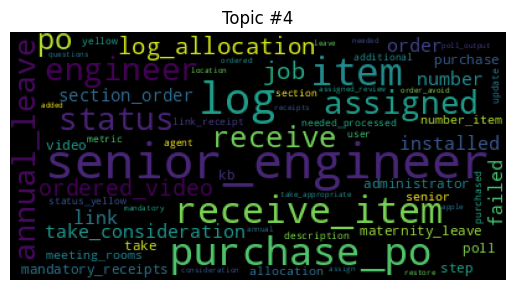

In [ ]:
for t in range(label_lda_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(label_lda_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

In [ ]:
label_ldamulti_model = LdaMulticore(corpus=corpus,
                         id2word=id2word,
                         num_topics=num_topics,
                         eta=eta_label,
                         chunksize=chunksize,
                         passes=passes,
                         iterations=iterations,
                         eval_every = eval_every,
                         random_state=42,
                         per_word_topics=True)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
getLDAModelAccuracy(label_ldamulti_model,corpus,data,"Label")

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.43533333333333335

In [ ]:
for num, params in label_ldamulti_model.print_topics():
    print(f'{num}: {params}\n')

0: 0.034*"la" + 0.034*"si" + 0.023*"va" + 0.020*"senior_engineer" + 0.019*"ca" + 0.016*"care" + 0.015*"engineer" + 0.014*"se" + 0.010*"sa" + 0.010*"assigned"

1: 0.020*"purchase_po" + 0.018*"item" + 0.018*"receive_item" + 0.016*"link" + 0.014*"receive" + 0.013*"upgrade" + 0.013*"log" + 0.012*"order" + 0.011*"log_allocation" + 0.011*"administrator"

2: 0.021*"importance_high" + 0.015*"issue" + 0.013*"en" + 0.013*"could" + 0.011*"working" + 0.011*"let_know" + 0.011*"laptop" + 0.010*"engineer" + 0.010*"senior" + 0.009*"server"

3: 0.045*"access" + 0.031*"event" + 0.029*"th_floor" + 0.022*"access_card" + 0.021*"disk" + 0.020*"name" + 0.018*"lost_access" + 0.017*"floor" + 0.016*"details" + 0.014*"th"

4: 0.089*"card" + 0.033*"cards" + 0.029*"visitor" + 0.025*"leaver" + 0.024*"floor" + 0.020*"visitor_cards" + 0.019*"area" + 0.019*"form" + 0.015*"find_attached" + 0.013*"analyst_ext"



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
c_v_coherence_model_labelldamulti = CoherenceModel(model=label_ldamulti_model, texts=docs, dictionary=dictionary, coherence='c_v')
c_v_coherence_labelldamulti = c_v_coherence_model_labelldamulti.get_coherence()
print('\nC_V Coherence Score: ', c_v_coherence_labelldamulti)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



C_V Coherence Score:  0.42955230089389895


In [ ]:
u_mass_coherence_model_lda_multicore = CoherenceModel(model=label_ldamulti_model, texts=docs, dictionary=dictionary, coherence='u_mass')
u_mass_coherence_lda_multicore = u_mass_coherence_model_lda_multicore.get_coherence()
print('\nu_mass Coherence Score: ', u_mass_coherence_lda_multicore)


u_mass Coherence Score:  -5.945341401586484


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
c_uci_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_uci')
c_uci_coherence_lda_multicore = c_uci_coherence_model_lda_multicore.get_coherence()
print('\nc_uci Coherence Score: ', c_uci_coherence_lda_multicore)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



c_uci Coherence Score:  -5.8686749016444235


In [ ]:
c_npmi_coherence_model_lda_multicore = CoherenceModel(model=lda_multicore_model, texts=docs, dictionary=dictionary, coherence='c_npmi')
c_npmi_coherence_lda_multicore = c_npmi_coherence_model_lda_multicore.get_coherence()
print('\nc_npmi Coherence Score: ', c_npmi_coherence_lda_multicore)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



c_npmi Coherence Score:  -0.15961908661182134


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


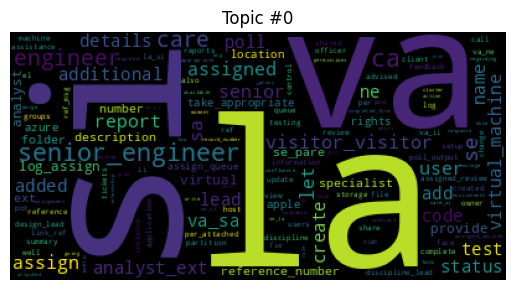

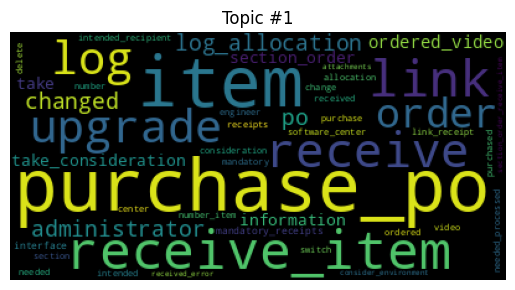

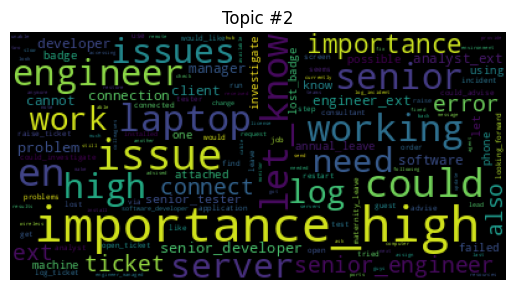

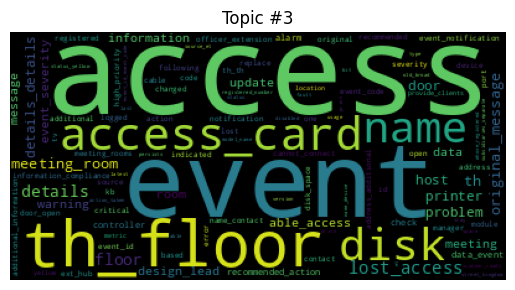

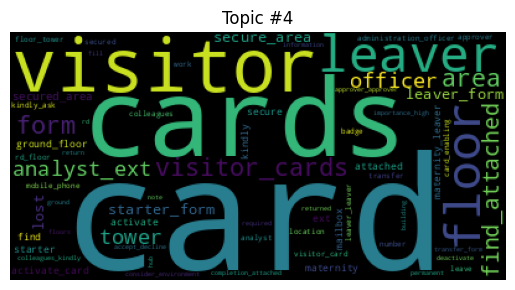

In [ ]:
for t in range(label_ldamulti_model.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(label_ldamulti_model.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()